In [4]:
%pylab inline
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import os
from scipy import ndimage

Populating the interactive namespace from numpy and matplotlib


"cp1242"

In [72]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=87.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=140.0 # masa del Kart con piloto(kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=0.01 # Inercia motor de combustión 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
illTotal=2*illd+illt*2

rpi=0.01525 # Radio Piñon (m)
rpla=0.10775 # Radio Plato (m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.01 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2)+((mpla*(rpla**2))/2) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2036 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.0960 # Altura del centro de gravedad del kart con respecto al piso (m)
masa_eq=((illTotal)+(ieje)+(ii*ng**2))/refc**2
def accel(vx, ddt):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)

    return wr*fr*cos(theta) # (N)

# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*sin(theta) # (N)

# Fuerza de arrastre
def farrastre(vx):
    return (1/2.0)*rho*af*cd*(vx+vw)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

def TorqueMotor(a_i,v_i):
    T=(masa+masa_eq)*a_i+frodadura(v_i,a_i)+farrastre(v_i)
    T=T*refc/(ng-etaf)
    if T<0:
        T=0
    return T
# Aceleración, Fuerza de tracción
# mr=(((ii-ig)*ng^2)+ieje+illd*2+illt*2)/(refc^2) 
# ax=(((ti*ng*etaf)/refc)-Fg-Fw-Fr)/(m+mr) # (m/s)

# Velocidad angular del motor
def vAngularMotor(vx):
    a=(vx*ng)/refc
    if a<(50*(2*pi)/60):
        a=50*(2*pi)/60
    if a>(5000*(2*pi)/60):
        a=5000*(2*pi)/60
    return a # (rad/s)

In [73]:
def importVBoxNuevo(tipoEnergia,nombre): #tipoEnergia=(electrico,combustion)
    direccion='data_'+tipoEnergia
    nombreArchivo=nombre
    datosCompleto=pd.read_table(os.path.join(direccion,nombreArchivo),sep="\s+",header=61, 
                                names=["sats","time","lat","long","velocity","heading","height","longacc","latacc","temp","Vbat","batt-flags","batt-ai","batt.soc"])
    datosDef=datosCompleto.drop(["longacc","latacc","temp","Vbat","batt-flags","batt-ai","batt.soc"],axis=1)
    return datosDef

In [74]:
def importVBoxViejo(tipoEnergia,nombre): #tipoEnergia=(electrica,combustion)
    direccion='data_'+tipoEnergia
    nombreArchivo=nombre
    datosCompleto=pd.read_table(os.path.join(direccion,nombreArchivo),sep="\s+",header=26)
    datosDef=datosCompleto.drop(["vert-vel","pot","event-1"],axis=1)
    return datosDef

In [75]:
def corteDatosElectrico(x):
    a=[]
    ini=4000
    nPuntos=1861
    fin=ini+nPuntos
    for i,v in enumerate (x):
        if i>=ini:
            if i<=fin:
                a.append(v)
    return asarray(a)

In [76]:
def derivacionNumerica(vel,time):
    a=[]
    dt=time[1]-time[0]
    for i,v in enumerate (vel):
        if i<(len(vel)-1):
            acel=(vel[i+1]-vel[i])/dt
            a.append(acel)
    return a

In [117]:

def graficarDesempeñoNuevo(tipoEnergia,nombre):
    
    datos=importVBoxNuevo(tipoEnergia,nombre)
    time0=corteDatosElectrico(array(datos['time']))
    lat0=corteDatosElectrico(array(datos['lat']))
    long0=corteDatosElectrico(array(datos['long']))
    vel0=corteDatosElectrico(array(datos['velocity']))
    
    torque=[]
    velAngular=[]
    potencia=[]
    
    time_base=time0[0]
    time0=time0-time_base
    lat0=lat0/60
    long0=long0/60
    acel0=derivacionNumerica(vel0,time0)
    for i,a in enumerate (acel0):
        
        torque.append(TorqueMotor(acel0[i],vel0[i]))
        velAngular.append(vAngularMotor(vel0[i]))
        P=TorqueMotor(acel0[i],vel0[i])*vAngularMotor(vel0[i])
        potencia.append(P)
    potencia=array(potencia)
    
    #posicion
    print ('Tiempo de Vuelta:',max(time0))
    plt.figure()
    plt.subplot(2,2,1)
    plt.title('Mapa')
    plt.axis('off')
    plt.plot(long0,lat0,'g')
    plt.annotate('Inicio',xy=(long0[0],lat0[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    
    #velocidad
    plt.subplot(2,2,2)
    plt.scatter(long0,lat0,c=vel0,cmap='OrRd')
    plt.xlim([min(long0)-0.0001,max(long0)+0.0001])
    plt.ylim([min(lat0)-0.0001,max(lat0)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Velocidad[m/s]')
    plt.annotate('Inicio',xy=(long0[0],lat0[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    plt.show()
    
    #aceleracion
    plt.figure()
    long00=[]
    lat00=[]
    for i,t in enumerate(long0):
        if i<len(long0)-1:
            long00.append(long0[i])
            lat00.append(lat0[i])
    long00=np.array(long00)
    lat00=np.array(lat00)
    plt.subplot(2,2,1)
    plt.scatter(long00,lat00,c=acel0,cmap='cool')
    plt.xlim([min(long0)-0.0001,max(long0)+0.0001])
    plt.ylim([min(lat0)-0.0001,max(lat0)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Aceleracion[m/s^2]')
    plt.annotate('Inicio',xy=(long0[0],lat0[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    plt.show()
    
    #Torque
    plt.subplot(2,2,2)
    plt.scatter(long00,lat00,c=torque,cmap='BrBG')
    plt.xlim([min(long0)-0.0001,max(long0)+0.0001])
    plt.ylim([min(lat0)-0.0001,max(lat0)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Torque Motor[Nm]')
    plt.annotate('Inicio',xy=(long0[0],lat0[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    plt.show()
    
    #velocidad angular motor
    plt.subplot(2,2,1)
    plt.scatter(long00,lat00,c=velAngular,cmap='Oranges')
    plt.xlim([min(long0)-0.0001,max(long0)+0.0001])
    plt.ylim([min(lat0)-0.0001,max(lat0)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Velocidad Angular Motor[rad/s]')
    plt.annotate('Inicio',xy=(long0[0],lat0[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    plt.show()
    
    #Potencia motor
    plt.subplot(2,2,2)
    plt.scatter(long00,lat00,c=potencia,cmap='bwr')
    plt.xlim([min(long0)-0.0001,max(long0)+0.0001])
    plt.ylim([min(lat0)-0.0001,max(lat0)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Potencia Motor[KW]')
    plt.annotate('Inicio',xy=(long0[0],lat0[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    plt.show()
    

In [119]:
importVBoxNuevo('electrico','VBS__052.VBO')

,sats,time,lat,long,velocity,heading,height
0,7,205344.85,297.765150,4436.984370,3.35,0.00,2586.05
1,7,205344.90,297.765198,4436.984412,4.27,0.00,2586.20
2,7,205344.95,297.765210,4436.984448,4.87,0.00,2586.34
3,7,205345.00,297.765228,4436.984490,5.36,0.00,2586.48
4,7,205345.05,297.765228,4436.984532,5.70,0.00,2586.61
5,7,205345.10,297.765222,4436.984562,5.91,142.57,2586.71
6,7,205345.15,297.765192,4436.984598,5.97,285.14,2586.79
7,7,205345.20,297.765168,4436.984628,5.85,286.03,2586.86
8,7,205345.25,297.765150,4436.984658,5.59,286.91,2586.92
9,7,205345.30,297.765132,4436.984682,5.08,286.69,2586.96


Tiempo de Vuelta: 480.4


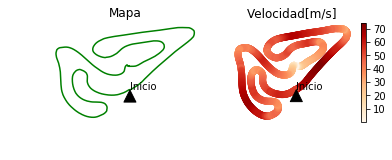

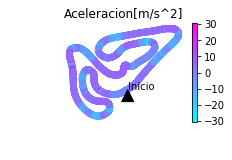

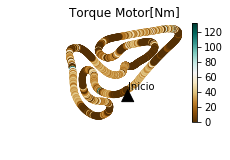

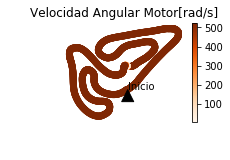

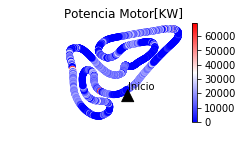

In [118]:
graficarDesempeñoNuevo('electrico','VBS__052.VBO')

Text(0,0.5,'velocidad (m/s)')

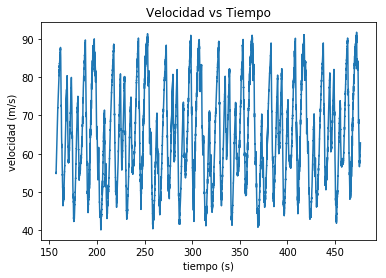

In [20]:
plot(time[15690:],vel[15690:])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

In [21]:
#m = Basemap(llcrnrlon=-73.94928,llcrnrlat=4.9627,urcrnrlon=-73.9511,urcrnrlat=4.9645,lat_ts=20,
            #resolution='f',projection='merc',lon_0=-73.950,lat_0=4.963)

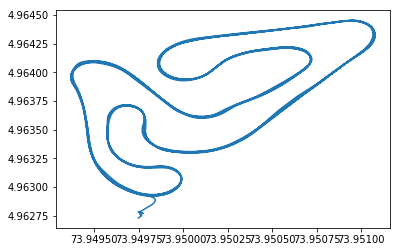

In [66]:
#x1,y1=m(long,lat)
#m.drawmapboundary(fill_color='white') # fill to edge
inicio = 15690
puntos = 5570
#m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
plot(-long,lat)

Text(0,0.5,'velocidad (m/s)')

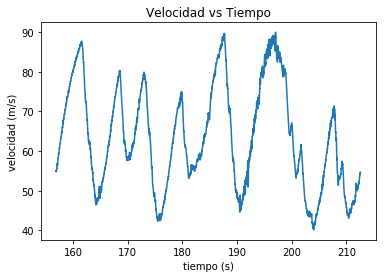

In [23]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

Text(0,0.5,'aceleracion (m/s^2)')

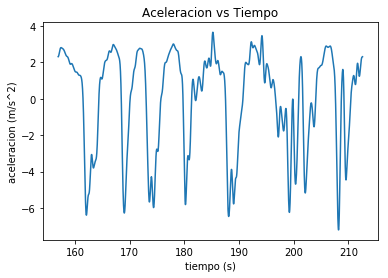

In [24]:


velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")



Text(0,0.5,'Fuerzas (N)')

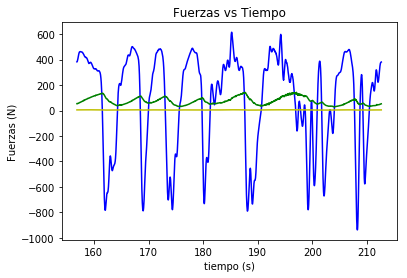

In [25]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b', label="Fuerza de traccion")
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g', label="Fuerza de arrastre")
plot(time[inicio:inicio+puntos],frod,'-y',label="Fuerza de rodadura")
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Fuerzas (N)")
#legend(loc="lower left")

Text(0,0.5,'torque (Nm)')

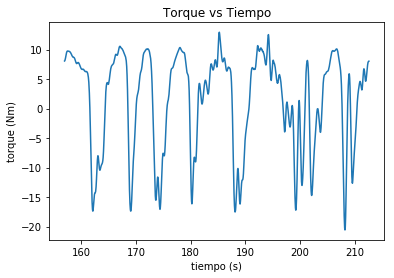

In [26]:


torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")



Text(0,0.5,'velocidad (RPM)')

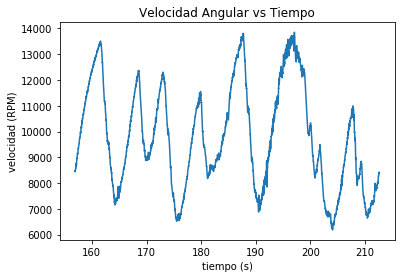

In [27]:


omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")



Text(0,0.5,'potencia (kW)')

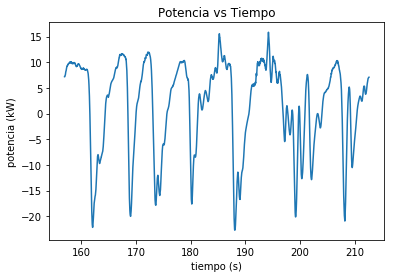

In [28]:


plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")



Text(0,0.5,'Torque (Nm)')

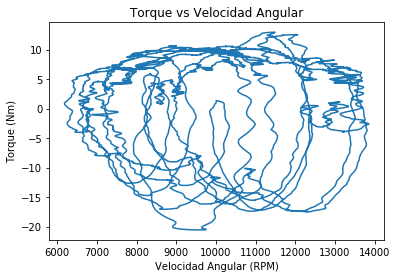

In [29]:
plot(omegam*30/np.pi,torque)
title("Torque vs Velocidad Angular")
xlabel("Velocidad Angular (RPM)")
ylabel ("Torque (Nm)")

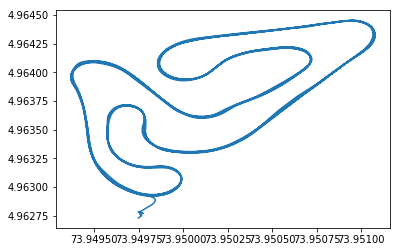

In [67]:
#x1,y1=m(long,lat)
#m.drawmapboundary(fill_color='white') # fill to edge
inicio = 21260
puntos = 5510
#m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
plot(-long,lat)

Text(0,0.5,'velocidad (m/s)')

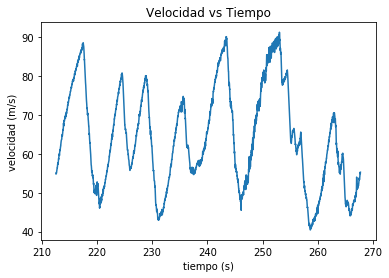

In [33]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

Text(0,0.5,'aceleracion (m/s^2)')

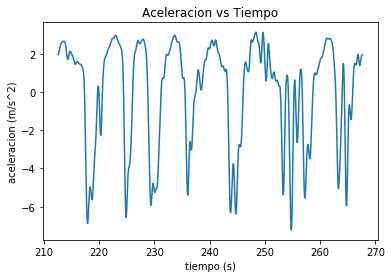

In [34]:


velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")



Text(0,0.5,'Fuerza (N)')

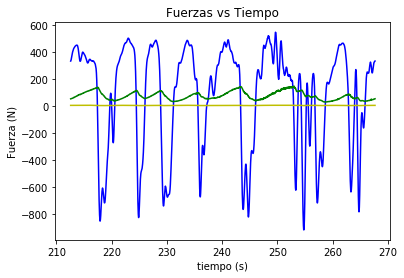

In [35]:


finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Fuerza (N)")



Text(0,0.5,'Torque (Nm)')

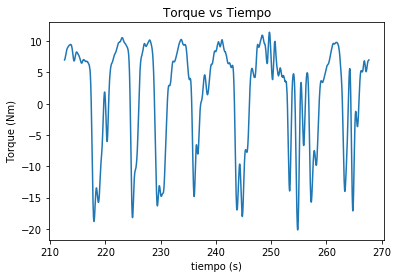

In [36]:


torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Torque (Nm)")



Text(0,0.5,'velocidad (RPM)')

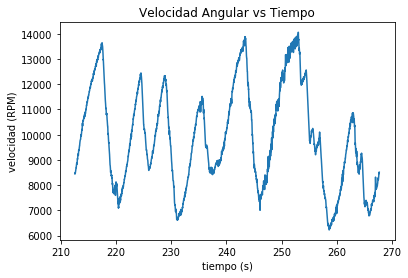

In [37]:


omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (RPM)")



Text(0,0.5,'Potencia (kW)')

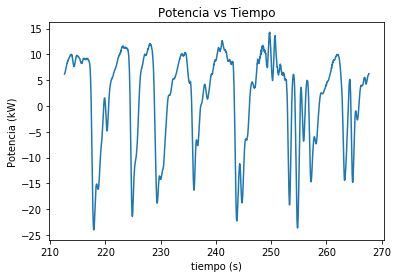

In [38]:
plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Potencia (kW)")

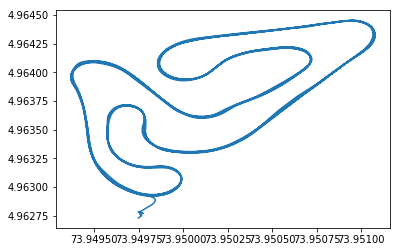

In [68]:
#x1,y1=m(long,lat)
#m.drawmapboundary(fill_color='white') # fill to edge
inicio = 26770
puntos = 5490
#m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
plot(-long,lat)

Text(0,0.5,'velocidad (m/s)')

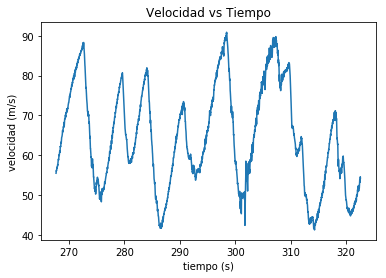

In [40]:


plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")



Text(0,0.5,'aceleracion (m/s^2)')

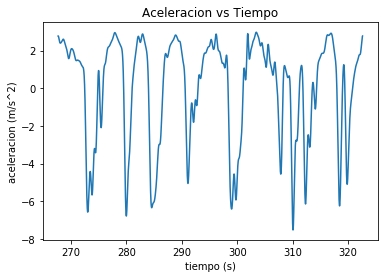

In [41]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

Text(0,0.5,'fuerza (N)')

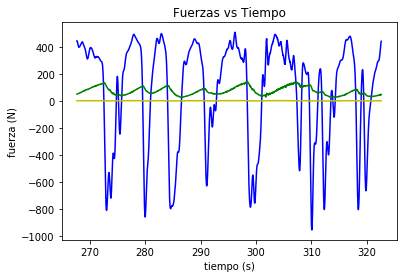

In [42]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("fuerza (N)")

Text(0,0.5,'torque(Nm)')

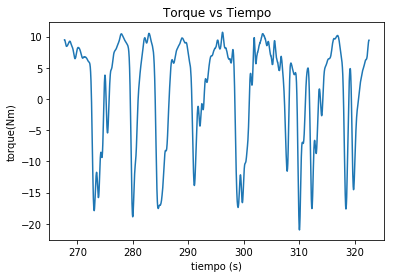

In [43]:
torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque(Nm)")

Text(0,0.5,'velocidad angular (RPM)')

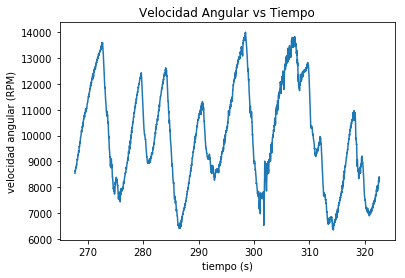

In [44]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad angular (RPM)")

Text(0,0.5,'potencia (kW)')

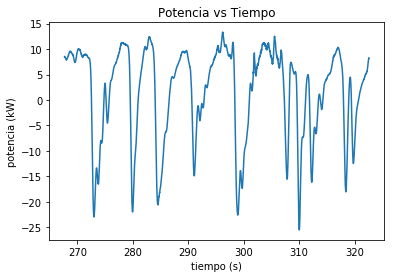

In [45]:


plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")



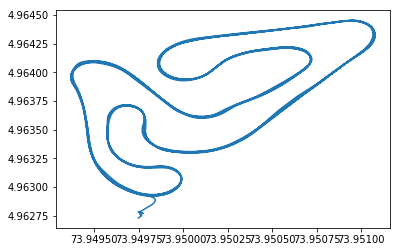

In [69]:
#x1,y1=m(long,lat)
#m.drawmapboundary(fill_color='white') # fill to edge
inicio = 32260
puntos = 5490
#m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
plot(-long,lat)

Text(0,0.5,'velocidad (m/s)')

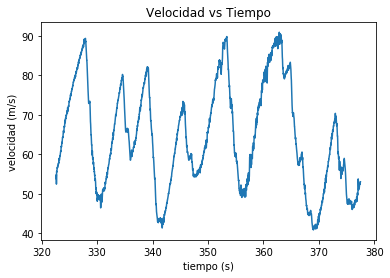

In [47]:
plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")

Text(0,0.5,'aceleracion (m/s^2)')

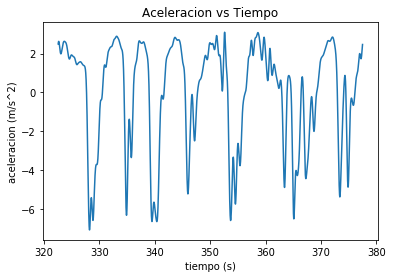

In [48]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

Text(0,0.5,'fuerza (N)')

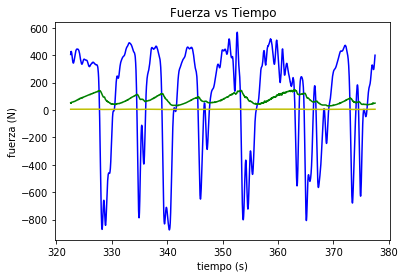

In [49]:
finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerza vs Tiempo")
xlabel("tiempo (s)")
ylabel ("fuerza (N)")

Text(0,0.5,'torque (Nm)')

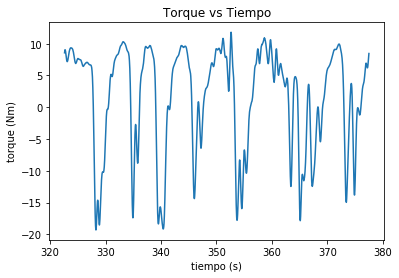

In [50]:


torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")



Text(0,0.5,'velocidad angular (RPM)')

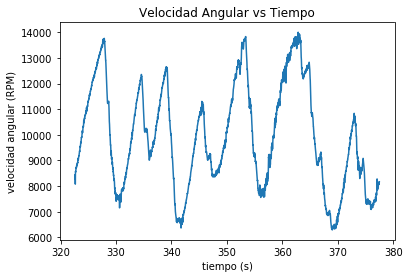

In [51]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad angular (RPM)")

Text(0,0.5,'potencia (kW)')

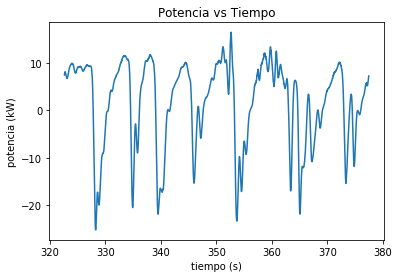

In [52]:


plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")



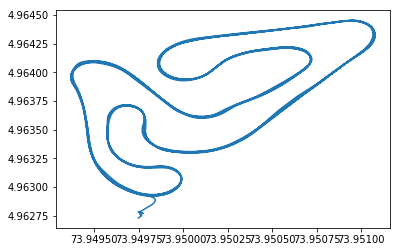

In [70]:
#x1,y1=m(long,lat)
#m.drawmapboundary(fill_color='white') # fill to edge
inicio = 37750
puntos = 5470
#m.scatter(x1[inicio:inicio+puntos],y1[inicio:inicio+puntos],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
plot(-long,lat)

Text(0,0.5,'velocidad (m/s)')

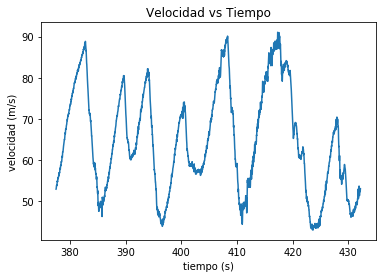

In [54]:


plot(time[inicio:inicio+puntos],vel[inicio:inicio+puntos])
title("Velocidad vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad (m/s)")



Text(0,0.5,'aceleracion (m/s^2)')

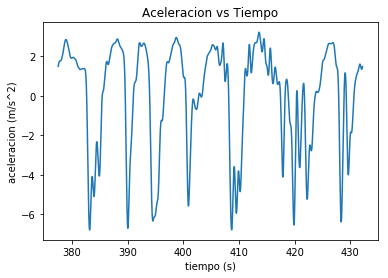

In [55]:
velms = vel/3.6
acx = accel(velms[inicio:inicio+puntos],dt)
plot(time[inicio:inicio+puntos],acx)
title("Aceleracion vs Tiempo")
xlabel("tiempo (s)")
ylabel ("aceleracion (m/s^2)")

Text(0,0.5,'Fuerza (N)')

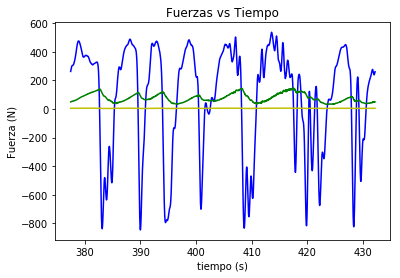

In [56]:


finc = finclinacion(theta)
farr = farrastre(velms[inicio:inicio+puntos])
frod = frodadura(vel[inicio:inicio+puntos],acx)
ftrac = ftraccion(acx,finc,farr,frod)
plot(time[inicio:inicio+puntos],ftrac,'-b')
#plot(time[inicio:inicio+puntos],finc)
plot(time[inicio:inicio+puntos],farr,'-g')
plot(time[inicio:inicio+puntos],frod,'-y')
title("Fuerzas vs Tiempo")
xlabel("tiempo (s)")
ylabel ("Fuerza (N)")



Text(0,0.5,'torque (Nm)')

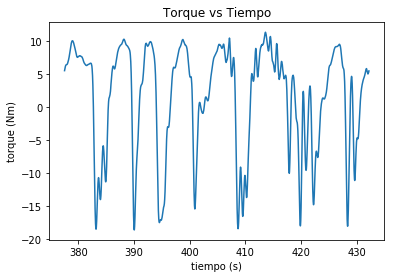

In [57]:


torque = torquemotor(acx,ftrac)
plot(time[inicio:inicio+puntos],torque)
title("Torque vs Tiempo")
xlabel("tiempo (s)")
ylabel ("torque (Nm)")



Text(0,0.5,'velocidad angular (RPM)')

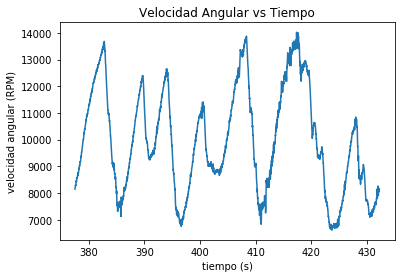

In [58]:
omegam = vangularmotor(velms[inicio:inicio+puntos])
plot(time[inicio:inicio+puntos],omegam*30/np.pi)
title("Velocidad Angular vs Tiempo")
xlabel("tiempo (s)")
ylabel ("velocidad angular (RPM)")

Text(0,0.5,'potencia (kW)')

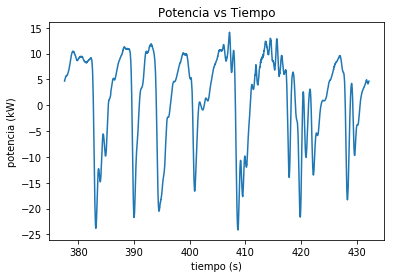

In [59]:
plot(time[inicio:inicio+puntos],omegam*torque/1000)
title("Potencia vs Tiempo")
xlabel("tiempo (s)")
ylabel ("potencia (kW)")

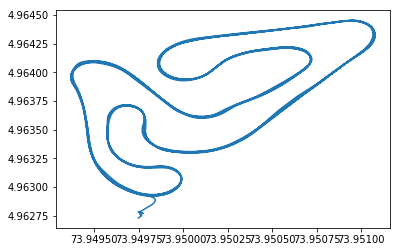

In [71]:
#x1,y1=m(long,lat)
#m.drawmapboundary(fill_color='white') # fill to edge
inicio = 43220
puntos = 5500
#m.scatter(x1[inicio:],y1[inicio:],s=5,c='r',marker="o",cmap=cm.jet,alpha=1.0)
plot(-long,lat)

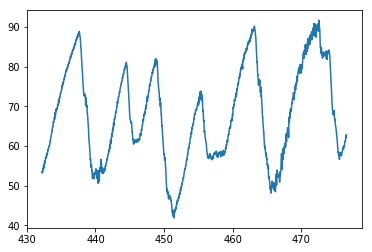

In [61]:


plot(time[inicio:],vel[inicio:])

